In [5]:
#---- Import necessary libraries ----#
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import pandas as pd
from astropy.constants import G, c, M_sun, hbar
import astropy.units as u
from scipy.optimize import fsolve


plt.rcParams.update({
    "text.usetex": True,                
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "figure.dpi": 200,                   
    "grid.alpha": 0.4,                    
})


# Dark matter

Adimensional 

$$

p'' = \frac{p}{m_f^4} \qquad \epsilon'' = \frac{\epsilon}{m_f^4}  \qquad  M'' =  \frac{M}{a} \qquad R'' =  \frac{R}{b}, \qquad a =  \frac{M_p^3}{m_f^2}, \qquad b = \frac{M_p}{m_f^2}
$$
$$

p' =p'' \frac{m_f^4}{4B} \qquad \epsilon' = \epsilon''\frac{m_f^4}{4B}
$$

# Quark matter


EoS MIT Bag Model

$$
p = \frac{1}{3}(\epsilon - 4 B)
$$

Adimensional 

$$

p' = \frac{p}{4B} \qquad \epsilon' = \frac{\epsilon}{4B}  \qquad  M' = 2\sqrt{B} \frac{M}{M_p^3} \qquad R' = 2\sqrt{B} \frac{R}{M_p}
$$
$$
p' = \frac{1}{3}(\epsilon' - 1)
$$


In [6]:

list_e_1 = np.linspace(1+2e-16, 100, 5000) # adimensional (divided by 4B)
list_p_1= 1/3 * (list_e_1 - 1) # adimensional (divided by 4B)

list_e_quark = list_e_1  # e'
list_p_quark = list_p_1  # p'


In [7]:
import numpy as np

delta_e = np.geomspace(1e-30, 99, 5000) # delta_e = e - 1

list_p_quark = delta_e / 3.0 # p = 1/3 * (e - 1)  becomes  p = 1/3 * delta_e

list_e_quark = 1.0 + delta_e

The EoS table is independent on the value of B.

In [8]:
# The EoS is independent of the mass scale, so we can work in dimensionless units
def p(z):
    factor = 1 / (24 * np.pi**2)
    term1 = (2*z**3-3*z)
    term2 = (1+z**2)**0.5
    term3 = 3 * np.arcsinh(z)
    return factor * (term1*term2 + term3) # p''

def e(z):
    factor = 1 / (8 * np.pi**2)
    term1 = (2*z**3 + z)
    term2 = (1+z**2)**0.5
    term3 = np.arcsinh(z)
    return factor * (term1*term2 - term3) # e''


# Define a large range of kf to cover the EoS
max_kf = 1e1
min_kf = 9e-4
number_points = int(5e4)

list_kf = np.linspace(min_kf, max_kf, number_points)

list_p_total = np.array(p(list_kf)) 
list_e_total = np.array(e(list_kf))

# Define scale factor to convert dimensionless units 
m_f = 1e5 # MeV
B = 145 ** 4 # MeV^4
scale_factor = m_f**4 / (4 * B)

# Select only the range of energy densities of interest
e_min = 1e-30
e_max = 1e-1
mask = (list_e_total >= e_min) & (list_e_total <= e_max)
list_e_DM = list_e_total[mask] * scale_factor
list_p_DM = list_p_total[mask] * scale_factor



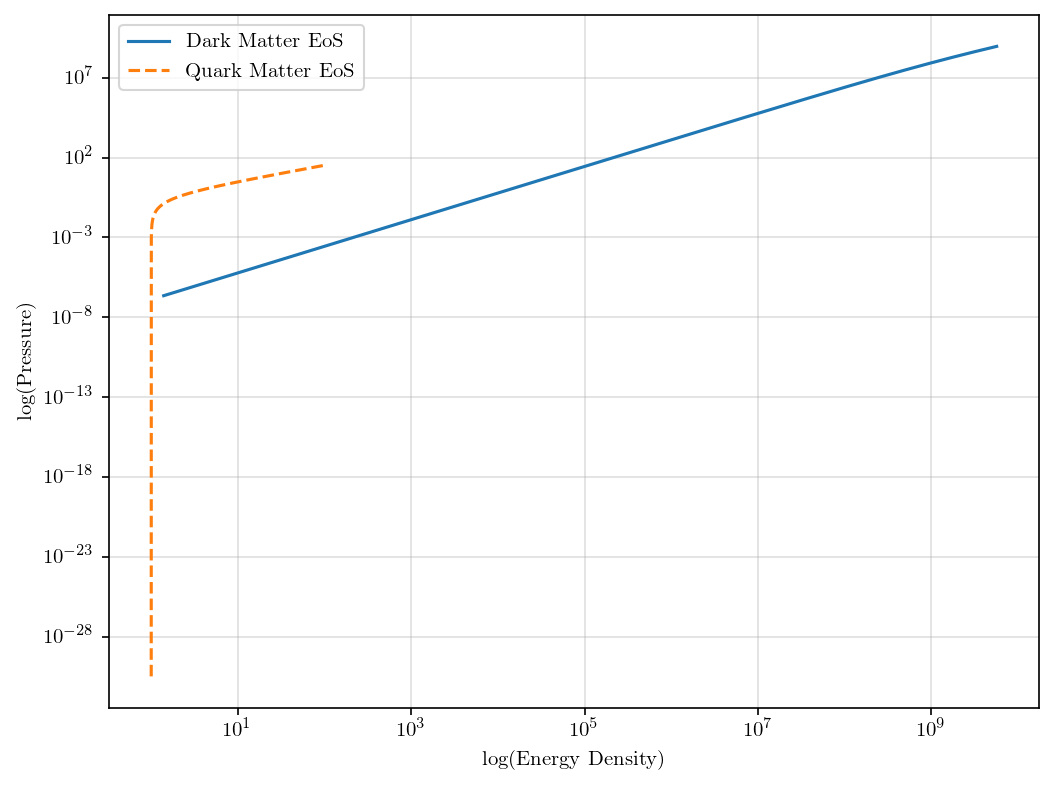

5000 5000
6413 6413
Quark EoS limits:
e_min = 1.00000000e+00
e_max = 1.00000000e+02
p_min = 3.33333333e-31
p_max = 3.30000000e+01

DM EoS limits:
e_min_dm = 1.39243405e+00
e_max_dm = 5.65451948e+09
p_min_dm = 2.25416502e-07
p_max_dm = 9.11269665e+08


In [9]:
# Plot the two EoS

plt.figure(figsize=(8,6), dpi=150)
plt.plot(list_e_DM, list_p_DM, label ='Dark Matter EoS')
plt.plot(list_e_quark, list_p_quark, linestyle='--', label ='Quark Matter EoS')
plt.xlabel('log(Energy Density)')
plt.xscale('log')
plt.yscale('log')

plt.ylabel('log(Pressure)')
plt.grid()
plt.legend()
plt.show()

print(len(list_e_quark), len(list_p_quark))
print(len(list_e_DM), len(list_p_DM))

#print maximums and minimums of the EoS
print("Quark EoS limits:")
e_min = min(list_e_quark)
e_max = max(list_e_quark)
p_min = min(list_p_quark)
p_max = max(list_p_quark)
print(f"e_min = {e_min:.8e}")
print(f"e_max = {e_max:.8e}")
print(f"p_min = {p_min:.8e}")
print(f"p_max = {p_max:.8e}")
print()

# print maximims and minimums dm
print("DM EoS limits:")
e_min_dm = min(list_e_DM)
e_max_dm = max(list_e_DM)
p_min_dm = min(list_p_DM)
p_max_dm = max(list_p_DM)
print(f"e_min_dm = {e_min_dm:.8e}")
print(f"e_max_dm = {e_max_dm:.8e}")
print(f"p_min_dm = {p_min_dm:.8e}")
print(f"p_max_dm = {p_max_dm:.8e}")

To solved the coupled equations, I need to use the same adimensionalization, otherwhise doesn't have physical sense.

The pressure and density are maximum at the core and go to zero toward the edges. therefore, the maximum values will set the maximum limit i can simulate for central conditions, but what is much more important is the values closer to zero.

The conditions I want to reproduce are:
- DM Central Pressure: $ 3 \times 10^6$ MeV/fm $^3$ 

In [10]:
hc = 197.3269804 # MeV fm

central_pressure_DM_physical = 3e6 * hc**3 #mev /fm^3# 
central_pressure_DM = central_pressure_DM_physical / (4 * B)
central_energy_DM = np.interp(central_pressure_DM, list_p_DM, list_e_DM)


print(f"Central pressure DM: {central_pressure_DM:.8e}")
print(f"Central energy DM:   {central_energy_DM:.8e}")


Central pressure DM: 1.30361295e+04
Central energy DM:   4.02277456e+06


DM conditons are $ \sim \times 10^6$ and my EoS goes until $ \sim \times 10^9$. More than enough. 

And in the low limit  $ \sim \times 10^{-7}$

In [11]:
#Initial conditions

r0 = 1e-6
central_energy_quark = 1000 * hc**3 / (4 * B) #1000 mev /fm^3# i want this specific value
central_pressure_quark = np.interp(central_energy_quark, list_e_quark, list_p_quark)
central_mass_quark = (4/3) * np.pi * r0**3 * central_energy_quark

central_pressure_DM = 3e6 * hc**3 / (4 * B) #3e6 mev /fm^3# i want this specific value
central_energy_DM = np.interp(central_pressure_DM, list_p_DM, list_e_DM)
central_mass_DM = (4/3) * np.pi * r0**3 * central_energy_DM


print(f"Central pressure quark: {central_pressure_quark:.8e}")
print(f"Central energy quark:   {central_energy_quark:.8e}")
print(f"Central mass quark:     {central_mass_quark:.8e}")
print()
print(f"Central pressure DM: {central_pressure_DM:.8e}")
print(f"Central energy DM:   {central_energy_DM:.8e}")
print(f"Central mass DM:     {central_mass_DM:.8e}")

Central pressure quark: 1.11512550e+00
Central energy quark:   4.34537649e+00
Central mass quark:     1.82018705e-17

Central pressure DM: 1.30361295e+04
Central energy DM:   4.02277456e+06
Central mass DM:     1.68505587e-11


Check that the central conditions are well defined in the EoS

For the selected initial conditions, See what the individuals profiles without interaction will look like

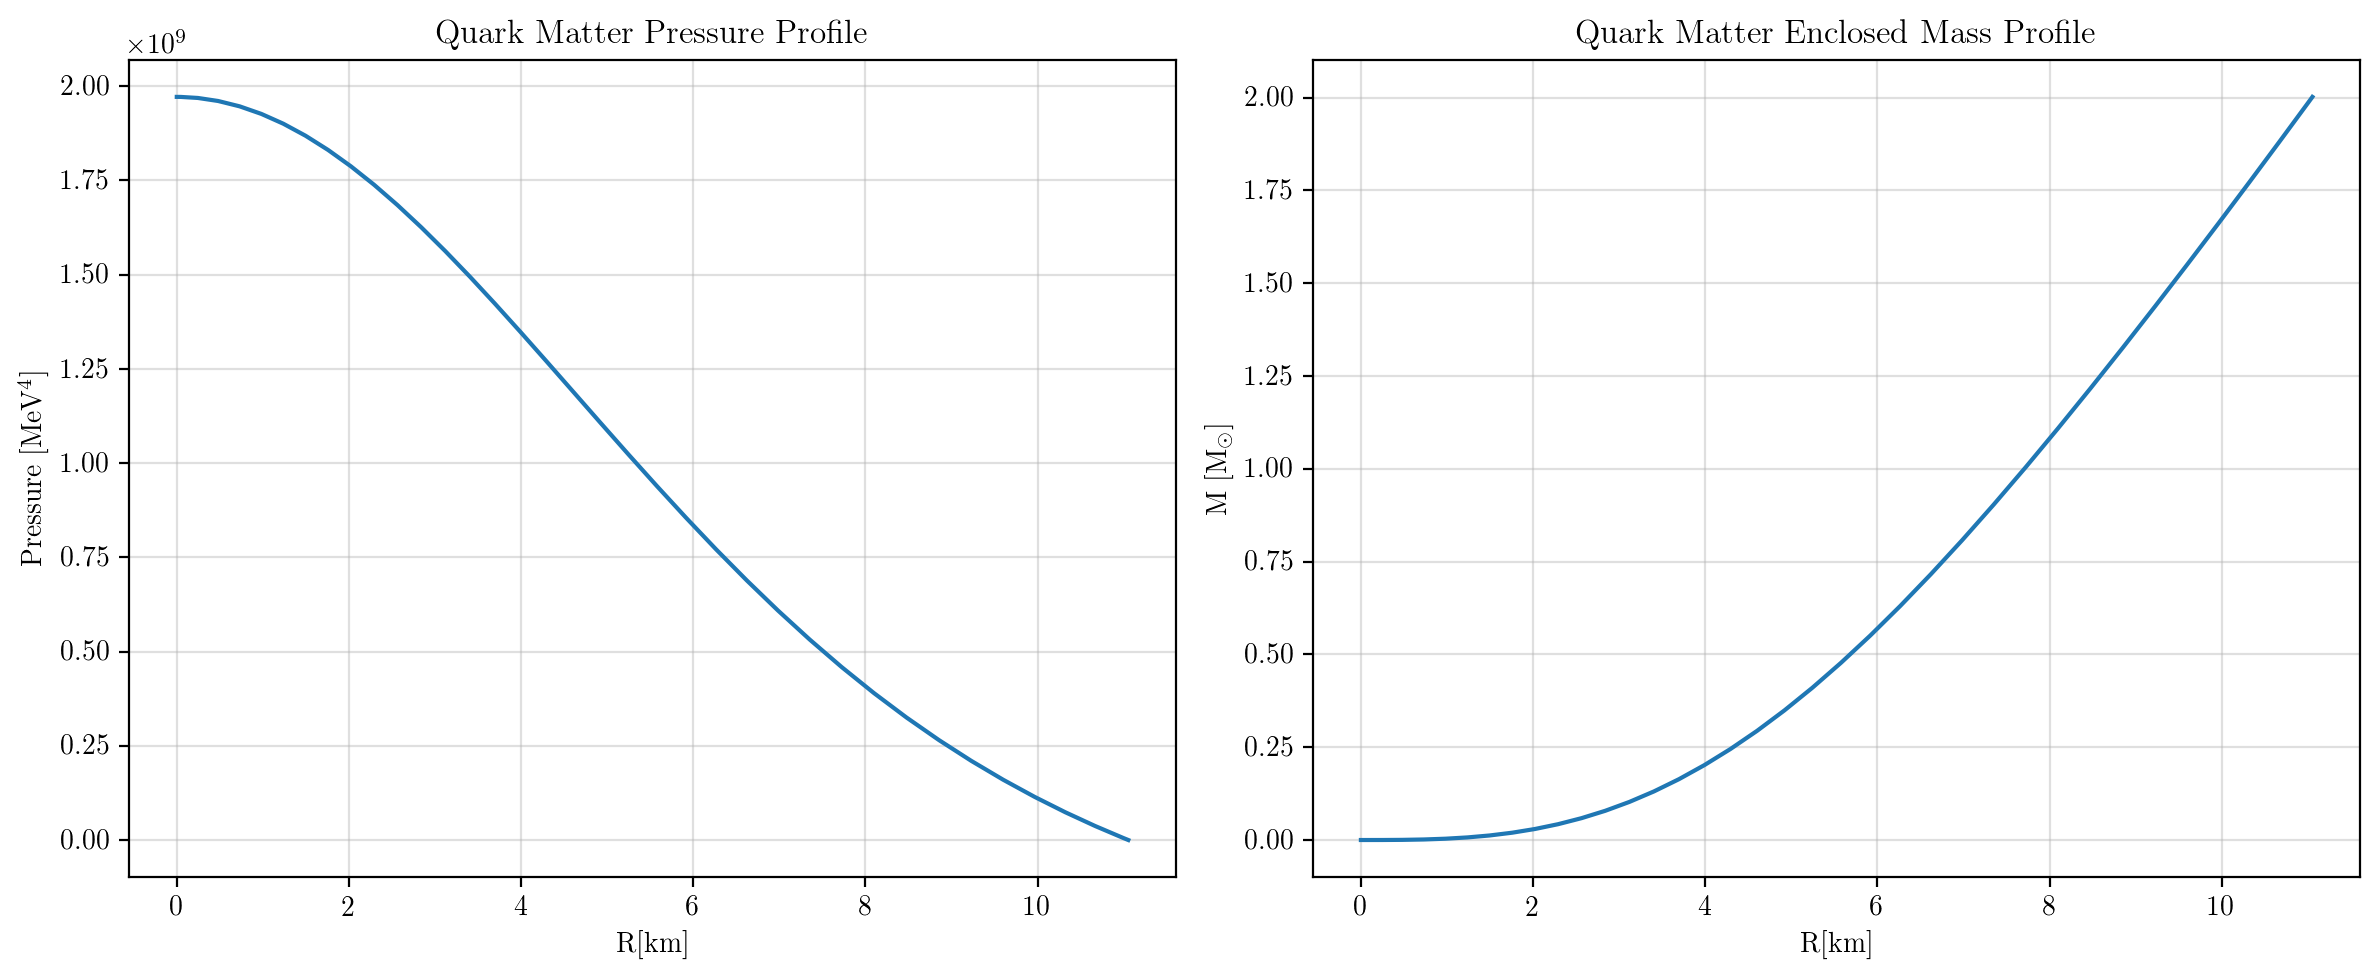

Final Pressure Quark Matter: -6.907819594811096e-08 MeV^4
Raw Final Pressure Quark Matter: -3.9066903224099593e-17


In [12]:

list_e_1_adim = list_e_quark
list_p_1_adim = list_p_quark

def solve_TOV(central_energy, x0):
    def ode_TOV_1(r, x):
            p, M = x
            if p < 0:
                return [0, 0]
            
            e = np.interp(p, list_p_1_adim, list_e_1_adim)

            term1 = e * M / r**2
            term2 = 1 + p / e
            if M == 0:
                term3 = 1.0
            else:
                term3 = 1.0 + 4 * np.pi * r**3 * p / M
            term4 = 1 - 2 * M / r

            if term4 <= 0:
                return [0, 0]

            dpdr = - term1 * term2 * term3 / term4
            dMdr =  4 * np.pi * r**2 * e

            return [dpdr, dMdr]

    
    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV_1,
        (r0, 1e10),     # integrate up to r=100 (large enough)
        x0,
        events=surface_event,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan, None, None, None
    

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan, None, None, None
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]

    if P_surface > 1e-5 :
        print("Final pressure is far from 0:", P_surface * (4 * B_1), 'MeV^4')
    P_profile = sol.y[0]
    M_profile = sol.y[1]
    R_profile = sol.t

    
    return R_surface, M_surface, P_profile, M_profile, R_profile


# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative


x0_quark = [central_pressure_quark, central_mass_quark]

R_surface, M_surface, P_profile, M_profile, R_profile = solve_TOV(central_energy_quark, x0_quark)




# Plot results
# ----------------------------------------------------
plt.figure(figsize=(12,5))

m_planck = np.sqrt((hbar * c) / G) # kg
M_p = (m_planck * c**2).to(u.MeV)
mev_to_kg = 1.78266192e-30 
msun_kg = 1.98847e30


plt.subplot(1,2,1)
#plt.plot(radius_km, pressure* (m_f**4))

R_km = R_profile  * M_p.value/ (2 * np.sqrt(B)) * hc * 1e-18 #km
Mass_mev = M_profile * M_p.value**3 / (2 * np.sqrt(B)) #MeV
Mass_sol = (Mass_mev * mev_to_kg) / msun_kg

plt.plot(R_km , P_profile * (4 * B) )
# recover units

plt.xlabel("R[km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.title(" Quark Matter Pressure Profile")
plt.grid()

plt.subplot(1,2,2)
#plt.plot(radius_km, mass_in_solar)
plt.plot(R_km, Mass_sol)
plt.xlabel("R[km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Quark Matter Enclosed Mass Profile")
plt.grid()

plt.tight_layout()
plt.show()

print(f"Final Pressure Quark Matter: {P_profile[-1] * (4 * B)} MeV^4")
print(f"Raw Final Pressure Quark Matter: {P_profile[-1] }")

In [13]:
list_e = list_e_DM
list_p = list_p_DM
def solve_TOV(central_energy, x0):

    def ode_TOV(r, x):
        p, M = x

        e = np.interp(p, list_p, list_e)

        if r < 1e-8:
            dpdr = 0.0
            dMdr = 4*np.pi*r**2*e
            return [dpdr, dMdr]

        term1 = (e + p)
        term2 = (M + 4*np.pi*r**3*p)
        term3 = r * (r - 2*M)

        dpdr = - term1 * term2 / term3
        dMdr =  4*np.pi * r**2 * e

        return [dpdr, dMdr]

    
    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    # This solver automatically adjusts step size to control error
    sol = solve_ivp(
        ode_TOV,
        (r0, 1e20),     # integrate up to r=1e5  corresponds to 
        x0,
        events=surface_event,
        rtol=1e-8, atol=1e-10 #tolerance error
    )

    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan, None, None, None
    
    M_surface = sol.y_events[0][0][1]
    P_surface = sol.y_events[0][0][0]
    R_surface = sol.t_events[0][0]


    if P_surface > 1e-10 :
        print("Final pressure is far from 0:", P_surface * (m_f**4), 'MeV^4')
    P_profile = sol.y[0]
    M_profile = sol.y[1]
    R_profile = sol.t

    
    return R_surface, M_surface, P_profile, M_profile, R_profile



# ----------------------------------------------------
# Event: stop integration when pressure goes to zero
# ----------------------------------------------------
def surface_event(r, x):
    return x[0]       # detects when between steps the pressure changes sign: pressure = 0, 
                      # the value given is not the pressure at that step, but an interpolation of where the pressure would be zero
surface_event.terminal = True # stop the integration
surface_event.direction = -1 # only detect zero-crossing from positive to negative

x0 = [central_pressure_DM, central_mass_DM]
R_surface, M_surface, P_profile, M_profile, R_profile= solve_TOV(central_energy_DM, x0)

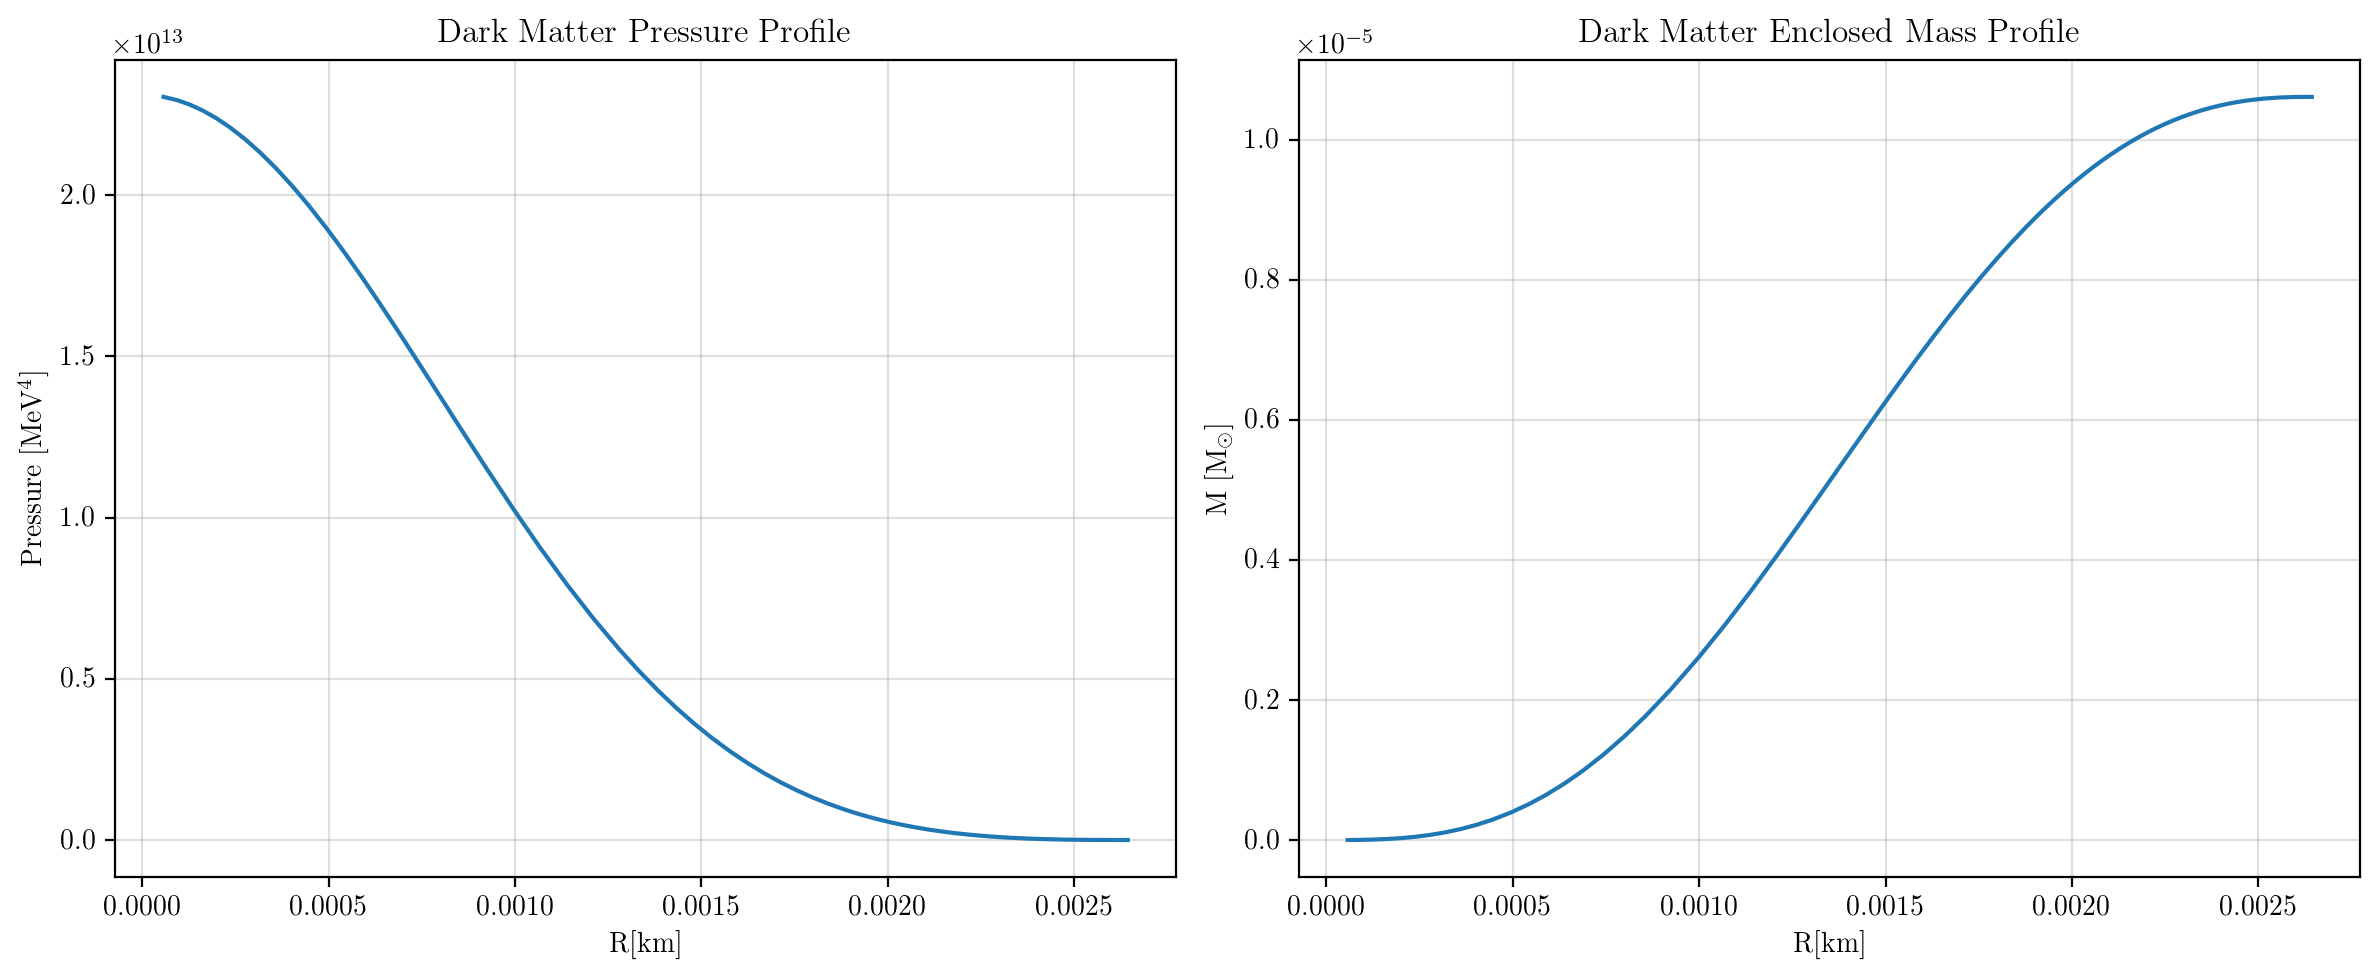

Final Pressure Dark Matter: -3.327143488337354e-05 MeV^4
Raw Final Pressure Quark Matter: 3.2281392178985695e-07


In [14]:

# Plot results
# ----------------------------------------------------
plt.figure(figsize=(12,5))

m_planck = np.sqrt((hbar * c) / G) # kg
M_p = (m_planck * c**2).to(u.MeV)
mev_to_kg = 1.78266192e-30 
msun_kg = 1.98847e30


plt.subplot(1,2,1)
#plt.plot(radius_km, pressure* (m_f**4))

R_km = R_profile  * M_p.value/ (2 * np.sqrt(B)) * hc * 1e-18 #km
Mass_mev = M_profile * M_p.value**3 / (2 * np.sqrt(B)) #MeV
Mass_sol = (Mass_mev * mev_to_kg) / msun_kg

plt.plot(R_km , P_profile * (4 * B) )
# recover units

plt.xlabel("R[km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.title("Dark Matter Pressure Profile")
plt.grid()

plt.subplot(1,2,2)
#plt.plot(radius_km, mass_in_solar)
plt.plot(R_km, Mass_sol)
plt.xlabel("R[km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Dark Matter Enclosed Mass Profile")
plt.grid()

plt.tight_layout()
plt.show()

# final pressure
print(f"Final Pressure Dark Matter: {P_profile[-1] * (4 * B)} MeV^4")
print(f"Raw Final Pressure Quark Matter: {P_profile[-2] }")

Both profiles share the same results in this code that in the individual codes. 

Two fluid

DM Surface found at R = 4.613887e-05
Quark Surface found at R = 1.939067e-01


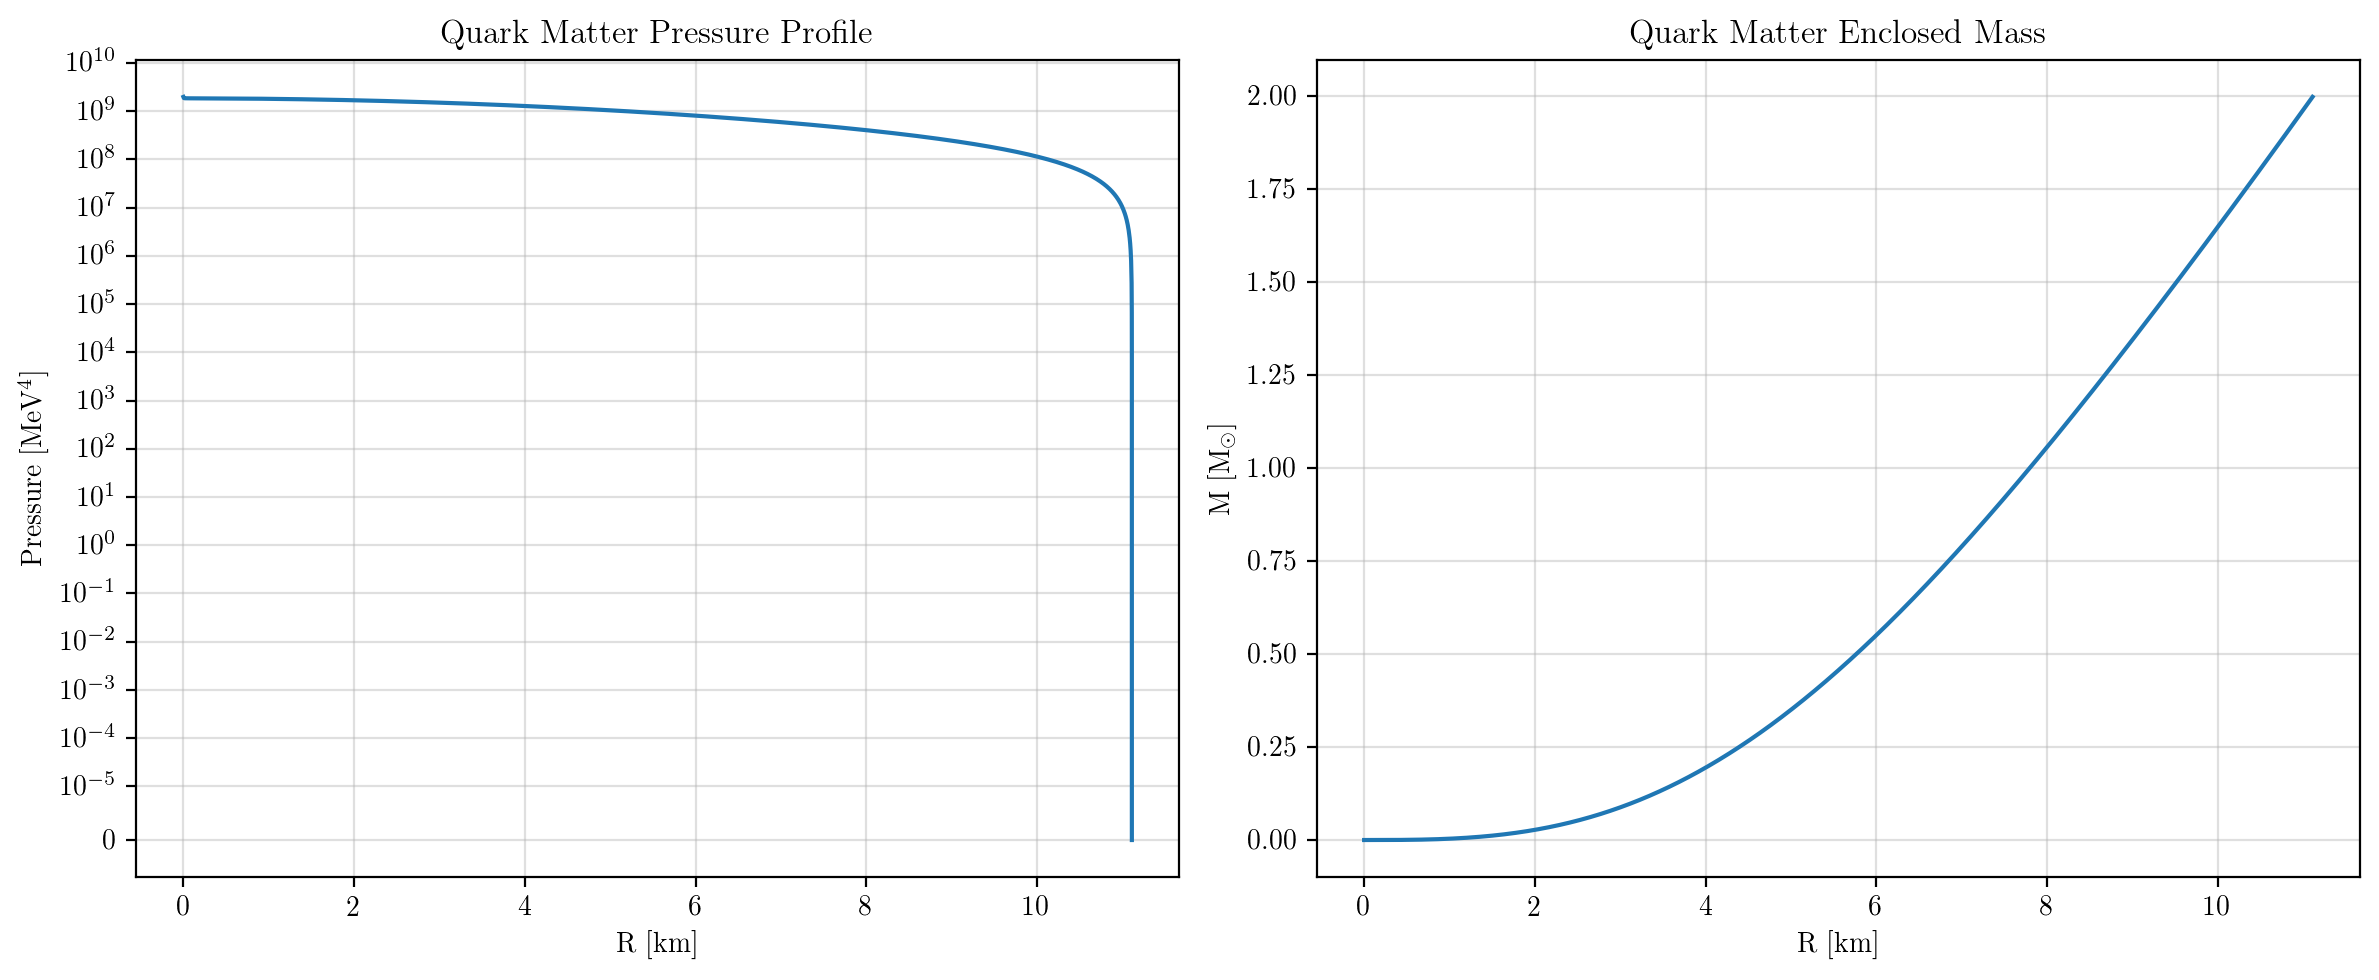

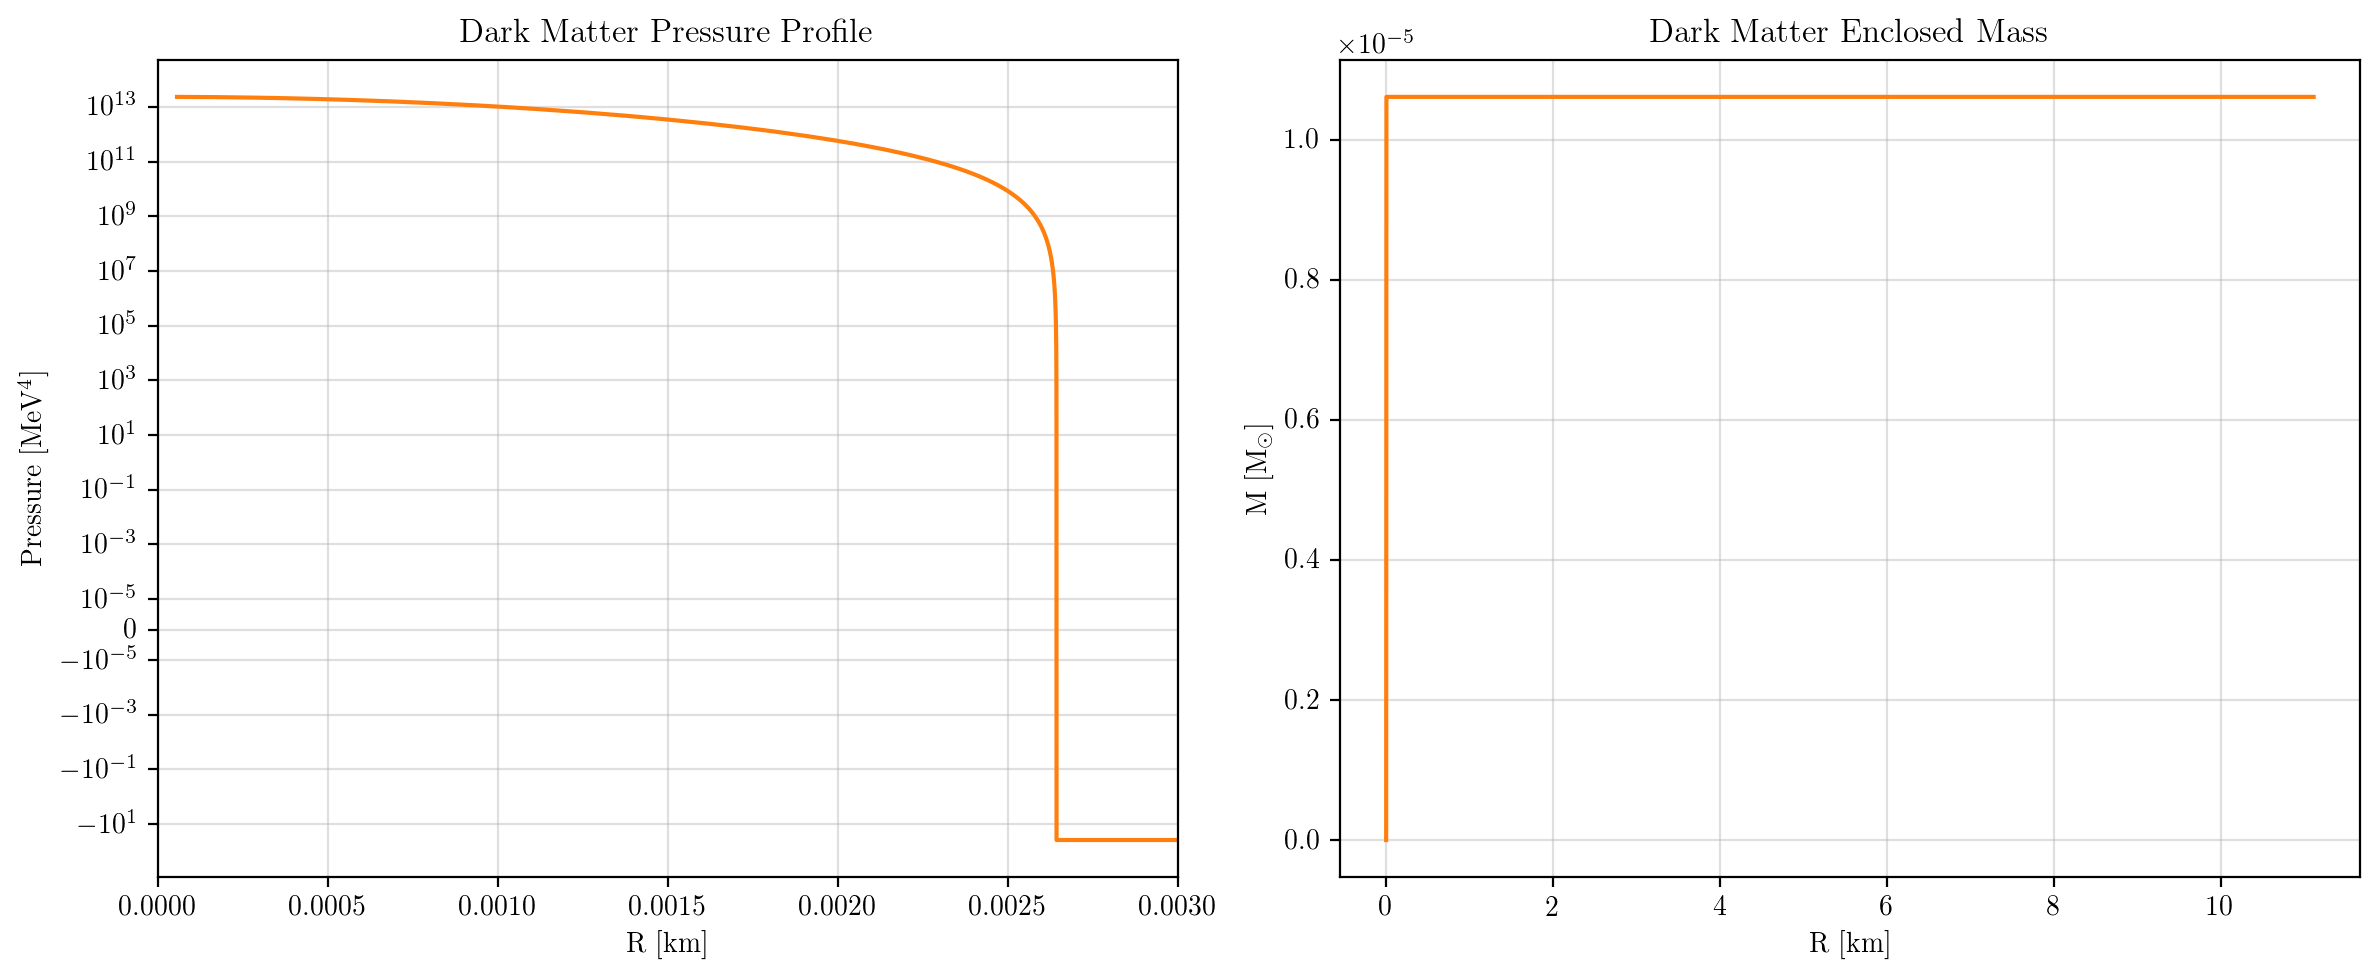

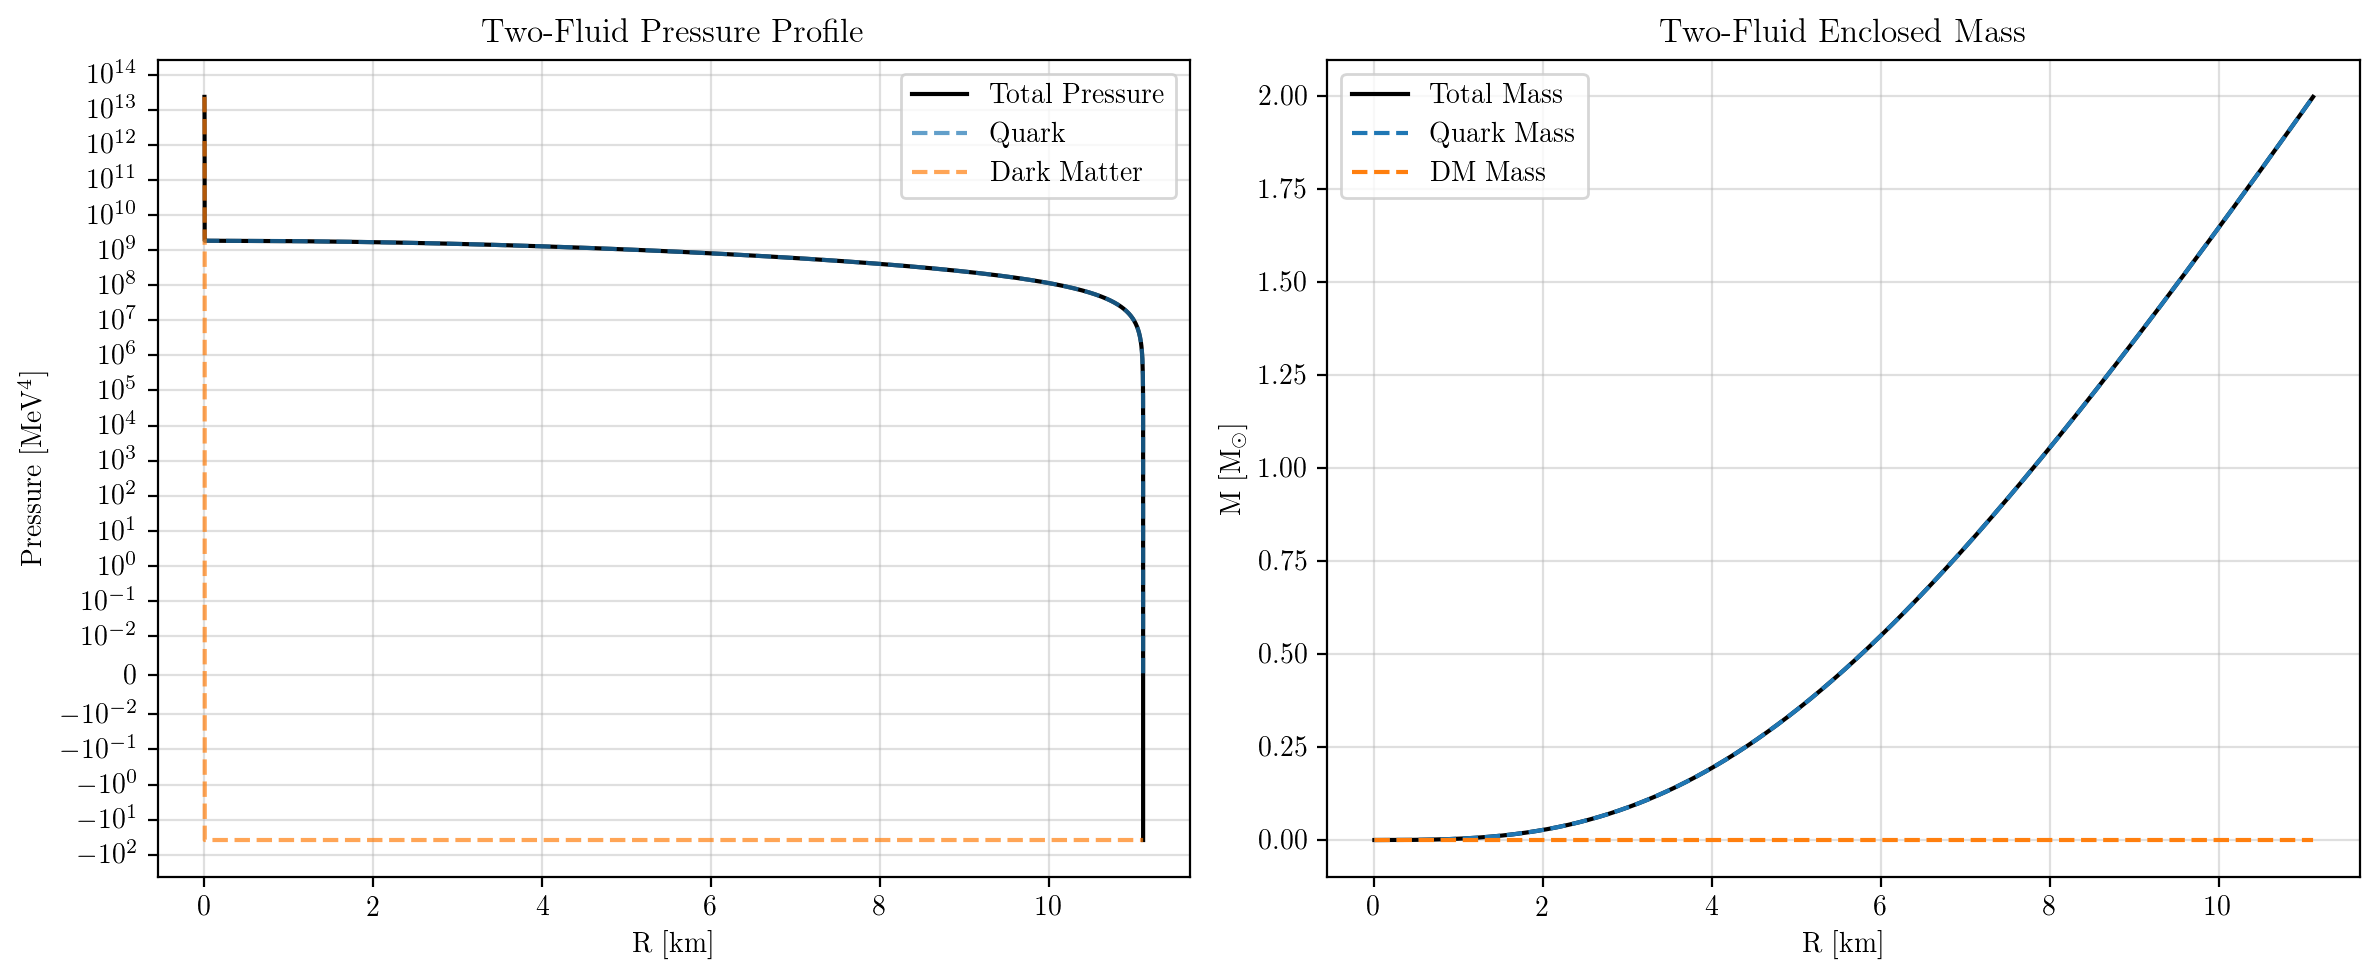

Total Radius: 11.1094 km
Total Mass:   1.9977 Solar Masses


In [15]:
# ----------------------------------------------------
# TOV equations
# ----------------------------------------------------

def ode_TOV(r, x):
    p1, M1, p2, M2 = x
    
    # If pressure is negative (overshoot), treat it as 0 for physics calculations
    p1_phys = max(0.0, p1)
    p2_phys = max(0.0, p2)

    if p1_phys > 0:
        e1 = np.interp(p1_phys, list_p_quark, list_e_quark)
    else:
        e1 = 0.0
        
    if p2_phys > 0:
        e2 = np.interp(p2_phys, list_p_DM, list_e_DM)
    else:
        e2 = 0.0
    
    M = M1 + M2

    # 3. CALCULATE METRIC TERMS (Using clean, physical variables)
    # Protection against r=0 division
    if r < 1e-9:
        dp1dr = 0.0
        dM1dr = 4 * np.pi * r**2 * e1
        dp2dr = 0.0
        dM2dr = 4 * np.pi * r**2 * e2
        return [dp1dr, dM1dr, dp2dr, dM2dr]

    term1_q = (e1 + p1_phys)
    term1_dm = (e2 + p2_phys)
    
    # Use p_phys here! This prevents the negative pressure from breaking gravity
    term2 = 1 + 4 * np.pi * r**3 * (p1_phys + p2_phys) / M
    term3 = 1 - 2 * M / r

    # Check for Horizon (Just in case, but unlikely with clean vars)
    if term3 <= 1e-9:
        return [0, 0, 0, 0] # or raise error

    # 4. CALCULATE DERIVATIVES
    # Fluid 1 (Quark)
    if p1 <= 0: # Check raw value for stopping condition
        dp1dr = 0.0
        dM1dr = 0.0 
    else:
        factor_1 = - M / r**2 # Standard TOV form G=c=1
        # dp/dr = -(e+p)(M + 4pi*r^3*p)/(r(r-2M))
        # Rearranged: - (M/r^2) * term1 * term2 / term3
        dp1dr = - (M / r**2) * term1_q * term2 / term3
        dM1dr = 4 * np.pi * r**2 * e1

    # Fluid 2 (Dark Matter)
    if p2 <= 0:
        dp2dr = 0.0
        dM2dr = 0.0
    else:
        dp2dr = - (M / r**2) * term1_dm * term2 / term3
        dM2dr = 4 * np.pi * r**2 * e2

    return [dp1dr, dM1dr, dp2dr, dM2dr]

# ----------------------------------------------------
# 1. Define the Events
# ----------------------------------------------------

def event_DM_surface(r, x):
    p2 = x[2]
    return p2 # The solver looks for when this returns 0
event_DM_surface.terminal = False  # Keep going! Quark matter might extend further.
event_DM_surface.direction = -1    # Only trigger when going from positive to negative.

def event_Quark_surface(r, x):
    p1 = x[0]
    return p1 
event_Quark_surface.terminal = True # Stop the integration. The star ends here.
event_Quark_surface.direction = -1

# ----------------------------------------------------
# 2. Run the Solver
# ----------------------------------------------------
x0 = [central_pressure_quark, central_mass_quark, central_pressure_DM, central_mass_DM]
sol = solve_ivp(
    ode_TOV, 
    (r0, 1e12), 
    x0, 
    events=[event_DM_surface, event_Quark_surface], # List of events
    rtol=1e-8, 
    atol=1e-10,
    max_step=1e-4 # Important for the tiny DM core
)

# ----------------------------------------------------
# 3. Extract the Exact Radii
# ----------------------------------------------------
# sol.t_events is a list of arrays, corresponding to the order of events passed above.
# Index 0 -> DM Surface
# Index 1 -> Quark Surface

# --- Handle Dark Matter Radius ---
if len(sol.t_events[0]) > 0:
    R_DM = sol.t_events[0][0] # The exact interpolated radius
    print(f"DM Surface found at R = {R_DM:.6e}")
else:
    R_DM = None 
    print("DM pressure never reached zero (or is larger than integration limit).")

# --- Handle Quark Matter Radius ---
if len(sol.t_events[1]) > 0:
    R_quark = sol.t_events[1][0] # The exact interpolated radius
    print(f"Quark Surface found at R = {R_quark:.6e}")
else:
    R_quark = None
    print("Quark pressure never reached zero.")


import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const

# ----------------------------------------------------
# 1. Setup Unit Conversions
# ----------------------------------------------------
# Constants (Assuming these from your previous context)
hbar = const.hbar.to(u.J * u.s).value
c = const.c.to(u.m / u.s).value
G = const.G.to(u.m**3 / (u.kg * u.s**2)).value

hc = 197.3269804  # MeV fm
B = 145**4        # MeV^4 (Bag Constant)

# Planck Mass in MeV
m_planck = np.sqrt((hbar * c) / G) # kg
M_p_MeV = (m_planck * c**2) / (1.60218e-13) # Convert J to MeV manually or use astropy .to(u.MeV).value

# Conversion Factors
# ------------------
# Radius: Adim -> km
# Formula: R_phys = R_adim * (M_p / (2*sqrt(B))) * (hbar*c in MeV*km?? No, careful with units here)
# Your snippet: R_km = R_profile * M_p.value/ (2 * np.sqrt(B)) * hc * 1e-18 
# Explanation: M_p [MeV] / sqrt(B) [MeV^2] -> [MeV^-1]. * hc [MeV fm] -> [fm]. * 1e-18 -> [km].
factor_R_to_km = (M_p_MeV / (2 * np.sqrt(B))) * hc * 1e-18

# Mass: Adim -> Solar Masses
# Formula: M_phys = M_adim * M_p^3 / (2*sqrt(B))
factor_M_to_MeV = M_p_MeV**3 / (2 * np.sqrt(B))
mev_to_kg = 1.78266192e-30 
msun_kg = 1.98847e30
factor_M_to_Solar = (factor_M_to_MeV * mev_to_kg) / msun_kg

# Pressure: Adim -> MeV^4
factor_P_to_MeV4 = 4 * B

# ----------------------------------------------------
# 2. Apply Conversions to Data
# ----------------------------------------------------
# Extract raw data from solver
r_adim = sol.t
p1_adim = sol.y[0] # Quark
m1_adim = sol.y[1]
p2_adim = sol.y[2] # DM
m2_adim = sol.y[3]

# Convert to Physical Units
R_km = r_adim * factor_R_to_km

P1_phys = p1_adim * factor_P_to_MeV4
M1_phys = m1_adim * factor_M_to_Solar

P2_phys = p2_adim * factor_P_to_MeV4
M2_phys = m2_adim * factor_M_to_Solar

# ----------------------------------------------------
# 3. Plotting
# ----------------------------------------------------

# --- PLOT 1: Quark Matter Only ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(R_km, P1_phys, color='tab:blue')
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.yscale('symlog', linthresh=1e-5) 

plt.title("Quark Matter Pressure Profile")

plt.grid(True)


plt.subplot(1,2,2)
plt.plot(R_km, M1_phys, color='tab:blue')
plt.xlabel("R [km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Quark Matter Enclosed Mass")
plt.grid(True)

plt.tight_layout()
plt.show()

# --- PLOT 2: Dark Matter Only ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(R_km, P2_phys, color='tab:orange')
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.yscale('symlog', linthresh=1e-5)
plt.xlim(0.00,0.003)
plt.title("Dark Matter Pressure Profile")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(R_km, M2_phys, color='tab:orange')
plt.xlabel("R [km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Dark Matter Enclosed Mass")
plt.grid(True)

plt.tight_layout()
plt.show()

# --- PLOT 3: Two Fluids Combined ---
plt.figure(figsize=(12,5))

# Calculate Totals
P_total = P1_phys + P2_phys
M_total = M1_phys + M2_phys

plt.subplot(1,2,1)
# Plot total, but maybe dashes for individual components to see the structure
plt.plot(R_km, P_total, label='Total Pressure', color='black')
plt.plot(R_km, P1_phys, '--', label='Quark', color='tab:blue', alpha=0.7)
plt.plot(R_km, P2_phys, '--', label='Dark Matter', color='tab:orange', alpha=0.7)

plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.title("Two-Fluid Pressure Profile")
plt.legend()
plt.grid(True)
plt.yscale('symlog', linthresh=1e-2) # Highly recommended for 2-fluid due to scale difference!

plt.subplot(1,2,2)
plt.plot(R_km, M_total, label='Total Mass', color='black')
plt.plot(R_km, M1_phys, '--', label='Quark Mass', color='tab:blue')
plt.plot(R_km, M2_phys, '--', label='DM Mass', color='tab:orange')

plt.xlabel("R [km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Two-Fluid Enclosed Mass")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print Final Physical Values
print(f"Total Radius: {R_km[-1]:.4f} km")
print(f"Total Mass:   {M_total[-1]:.4f} Solar Masses")

the solver was not working at the beginning because my initial pressure and energy conditions for the quark matter where outside the boundaries of the grid of EoS

A flat profile means that the iteration started at a radius very small, inside the swarchild radius. Therefore the denominator is negative, pressure gradients are positive. The solver didnt work and is returning the initial values

## Results 
The simulation shows that the Dark Matter core is incredibly dense and compact. Its pressure drops from a massive value to zero in just 2.5 meters. This physically means that the Dark Matter is so heavy that its own gravity pulls it into the center, creating a vertical "cliff" in the pressure graph.

The flat line at negative pressure seen afterwards is just a computer error, not real physics. Because the pressure drops so sharply, the calculation "stepped" too far and landed on a negative number instead of hitting exactly zero. The code was designed to stop changing the pressure once it hit zero, so it simply got stuck on that negative number for the rest of the simulation. This confirms the physics engine is working, but the "negative tail" needs to be removed manually to make the graph accurate.

Central pressure quark: 1.11512550e+00
Central energy quark:   4.34537649e+00
Central mass quark:     1.82018705e-17

Central pressure DM: 1.30361295e+04
Central energy DM:   4.02277456e+06
Central mass DM:     1.68505587e-11
Quark Surface detected. Profile clamped at index 2242, R=1.9391e-01
DM Surface detected. Profile clamped at index 280, R=4.6139e-05


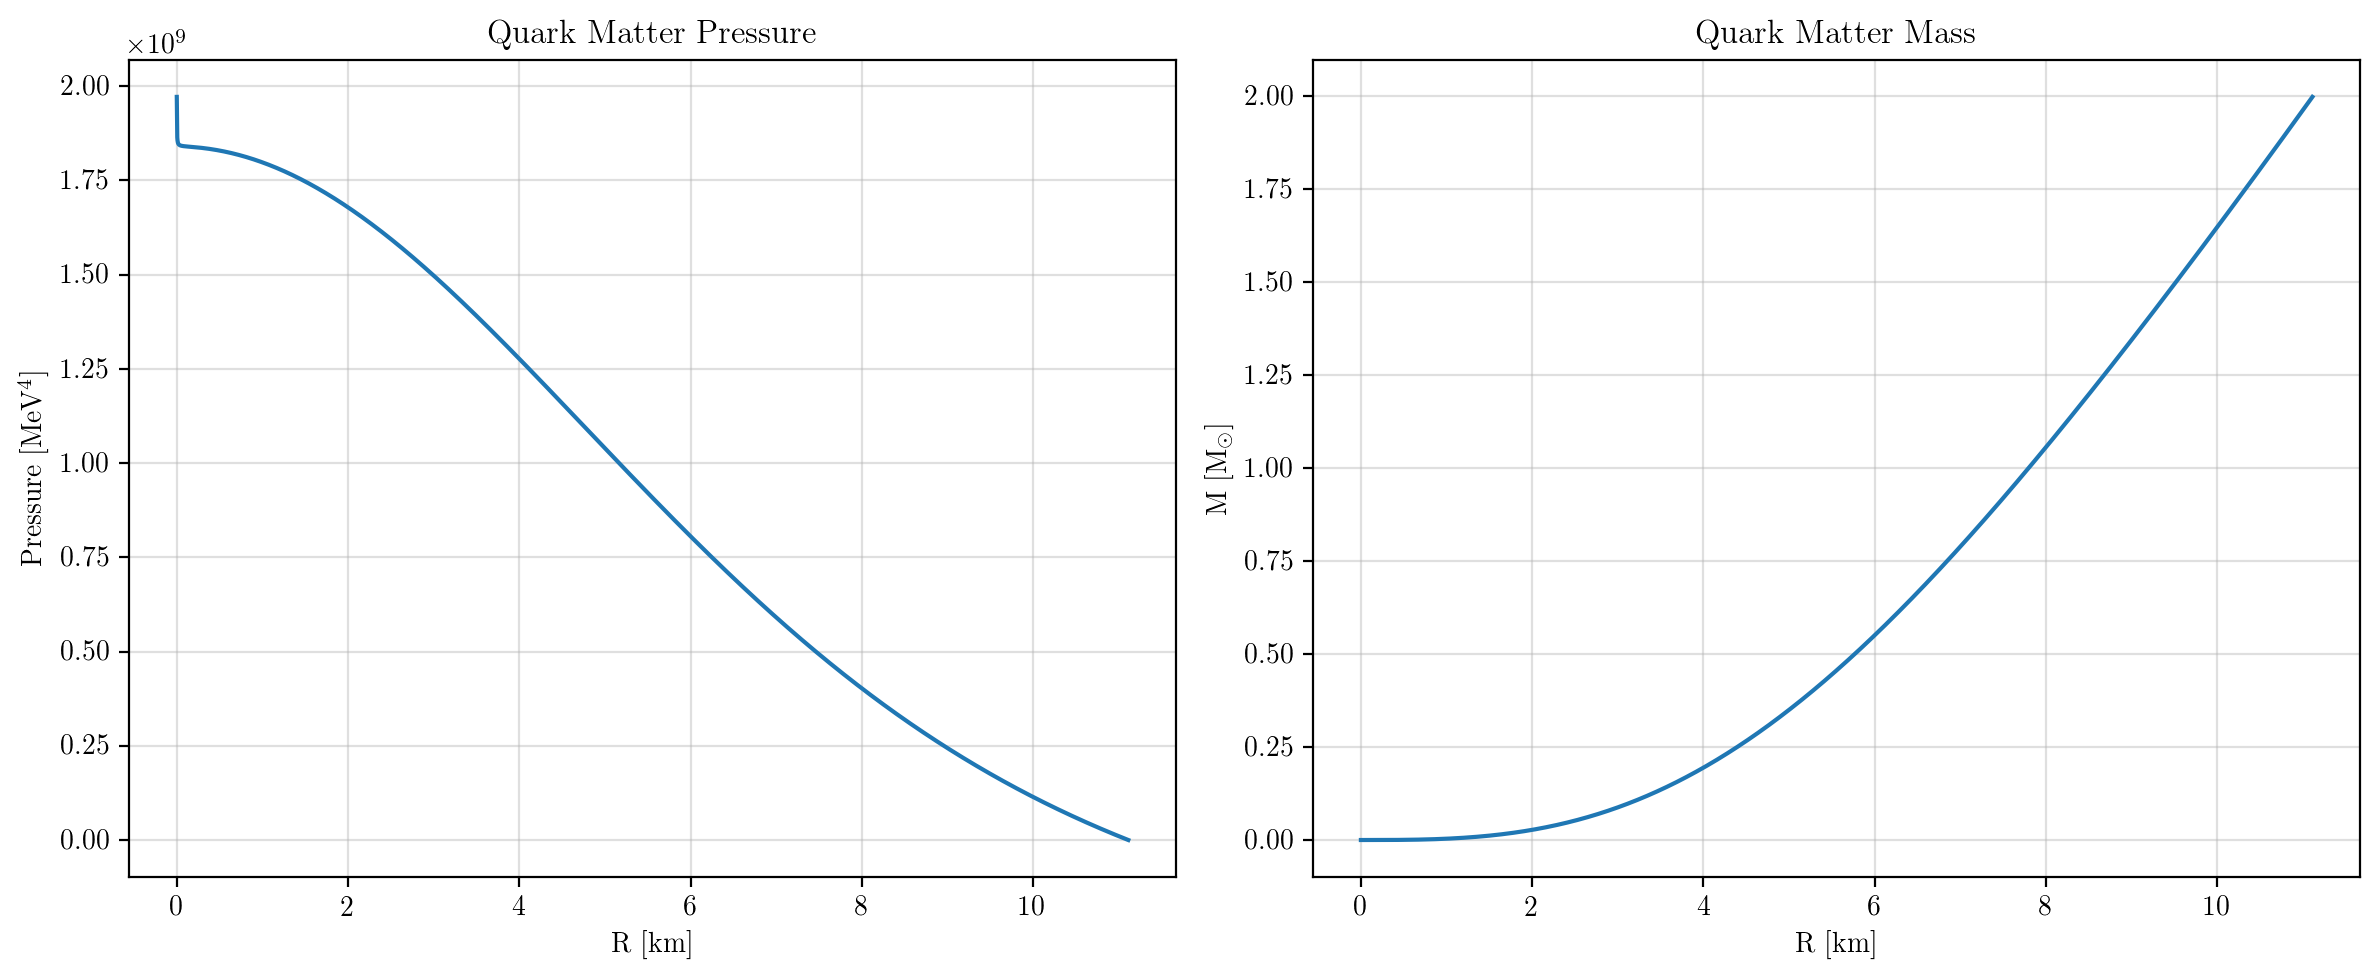

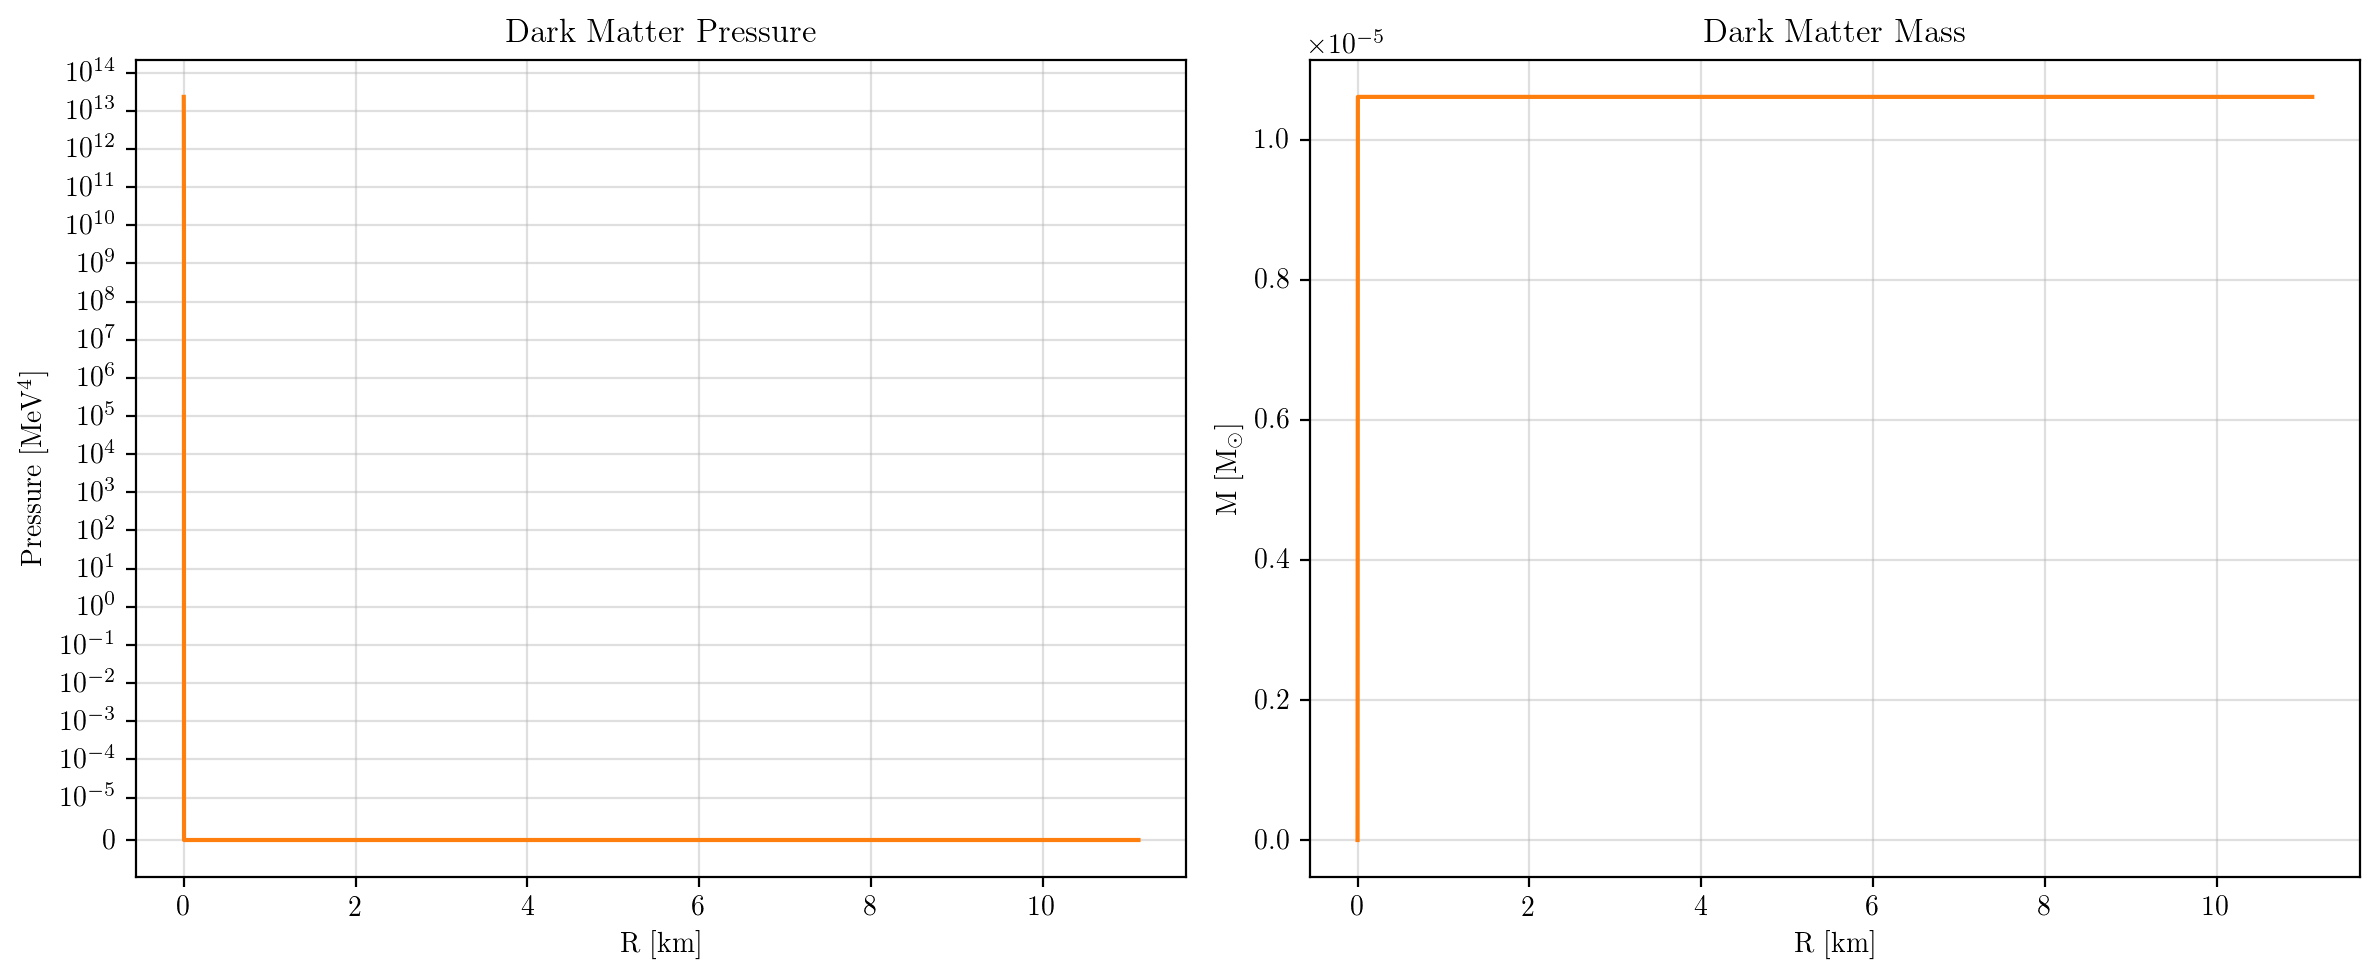

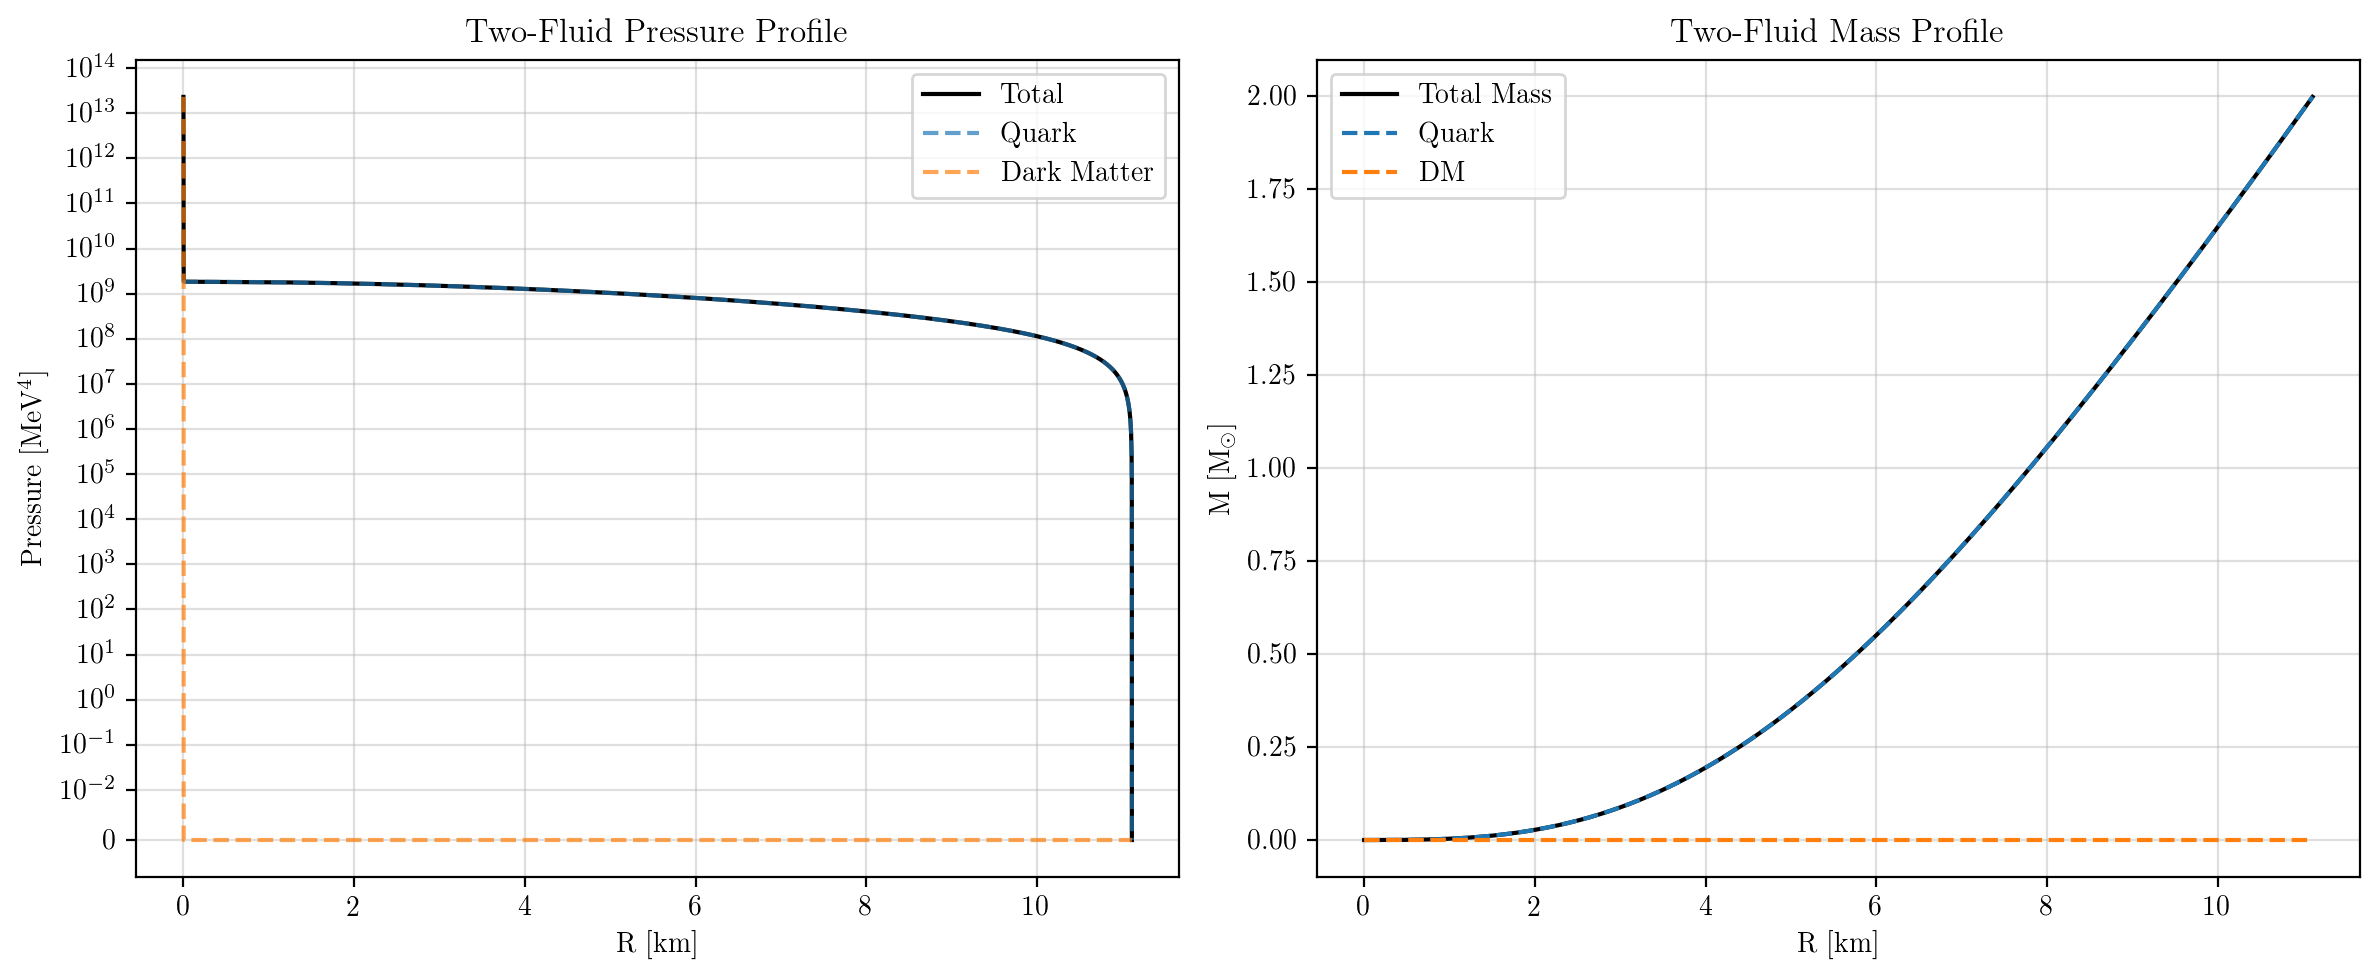

Final Quark Radius: 11.1094 km
Final DM Radius:    0.0026 km
Total Mass:   1.9977 Solar Masses


In [16]:

# ----------------------------------------------------
# 1. ODE Definition 
# ----------------------------------------------------
def ode_TOV(r, x):
    p1, M1, p2, M2 = x
    
    p1_phys = max(0.0, p1)
    p2_phys = max(0.0, p2) # Treat negative pressure as 0 for physics

    if p1_phys > 0:
        e1 = np.interp(p1_phys, list_p_quark, list_e_quark)
    else:
        e1 = 0.0
        
    if p2_phys > 0:
        e2 = np.interp(p2_phys, list_p_DM, list_e_DM)
    else:
        e2 = 0.0
    
    M = M1 + M2

    if r < 1e-9:
        return [0.0, 4 * np.pi * r**2 * e1, 0.0, 4 * np.pi * r**2 * e2]

    term1_q = (e1 + p1_phys)
    term1_dm = (e2 + p2_phys)
    term2 = 1 + 4 * np.pi * r**3 * (p1_phys + p2_phys) / M
    term3 = 1 - 2 * M / r

    if term3 <= 1e-9: # negative or zero, horizon reached
        return [0, 0, 0, 0]

    factor = - (M / r**2) / term3

    # Fluid 1 (Quark)
    if p1 <= 0: # If raw pressure is negative, stop contribution
        dp1dr = 0.0
        dM1dr = 0.0 
    else:
        dp1dr = factor * term1_q * term2
        dM1dr = 4 * np.pi * r**2 * e1

    # Fluid 2 (Dark Matter)
    if p2 <= 0: # If raw pressure is negative, stop contribution
        dp2dr = 0.0
        dM2dr = 0.0
    else:
        dp2dr = factor * term1_dm * term2
        dM2dr = 4 * np.pi * r**2 * e2

    return [dp1dr, dM1dr, dp2dr, dM2dr]

# ----------------------------------------------------
# 2. Events 
# ----------------------------------------------------
def event_DM_surface(r, x):
    return x[2]
event_DM_surface.terminal = False 
event_DM_surface.direction = -1

def event_Quark_surface(r, x):
    return x[0]
event_Quark_surface.terminal = True
event_Quark_surface.direction = -1

# ----------------------------------------------------
# 3. Solve
# ----------------------------------------------------

#Initial conditions

r0 = 1e-6
central_energy_quark = 1000 * hc**3 / (4 * B) #1000 mev /fm^3# i want this specific value
central_pressure_quark = np.interp(central_energy_quark, list_e_quark, list_p_quark)
central_mass_quark = (4/3) * np.pi * r0**3 * central_energy_quark

central_pressure_DM = 3e6 * hc**3 / (4 * B) #3e6 mev /fm^3# i want this specific value
central_energy_DM = np.interp(central_pressure_DM, list_p_DM, list_e_DM)
central_mass_DM = (4/3) * np.pi * r0**3 * central_energy_DM


print(f"Central pressure quark: {central_pressure_quark:.8e}")
print(f"Central energy quark:   {central_energy_quark:.8e}")
print(f"Central mass quark:     {central_mass_quark:.8e}")
print()
print(f"Central pressure DM: {central_pressure_DM:.8e}")
print(f"Central energy DM:   {central_energy_DM:.8e}")
print(f"Central mass DM:     {central_mass_DM:.8e}")

x0 = [central_pressure_quark, central_mass_quark, central_pressure_DM, central_mass_DM]

sol = solve_ivp(
    ode_TOV, 
    (r0, 1e12), 
    x0, 
    events=[event_DM_surface, event_Quark_surface],
    rtol=1e-8, 
    atol=1e-10,
    max_step=1e-4,
    first_step=1e-7 
)

# ----------------------------------------------------
# 4. Solutions
# ----------------------------------------------------
r_adim = sol.t.copy()
p1_adim = sol.y[0].copy()
m1_adim = sol.y[1].copy()
p2_adim = sol.y[2].copy()
m2_adim = sol.y[3].copy()

# --- LAST POSITIVE PRESSURE ---

# For Quark Matter
idx_q_valid = np.where(p1_adim > 0)[0] # Indices where pressure is positive

if len(idx_q_valid) > 0: 

    last_q_idx = idx_q_valid[-1] # Last index with positive pressure
    
    p1_adim[last_q_idx+1:] = 0.0 # Force all next pressures to 0.0
    
    R_quark_final = r_adim[last_q_idx]  # Store the radius of the last positive point

    print(f"Quark Surface detected. Profile clamped at index {last_q_idx}, R={R_quark_final:.4e}")
else:
    R_quark_final = None
    print("Quark pressure never positive or immediately zero.")


# For Dark Matter 
idx_dm_valid = np.where(p2_adim > 0)[0]

if len(idx_dm_valid) > 0:

    last_dm_idx = idx_dm_valid[-1]
    
    p2_adim[last_dm_idx+1:] = 0.0
    
    R_DM_final = r_adim[last_dm_idx]
    
    print(f"DM Surface detected. Profile clamped at index {last_dm_idx}, R={R_DM_final:.4e}")
else:
    R_DM_final = None
    print("DM pressure never positive or immediately zero.")


# ----------------------------------------------------
# 5. Unit Conversions & Plotting
# ----------------------------------------------------


factor_R_to_km = (M_p.value / (2 * np.sqrt(B))) * hc * 1e-18
factor_M_to_Solar = (M_p.value **3 / (2 * np.sqrt(B))) * mev_to_kg / msun_kg
factor_P_to_MeV4 = 4 * B


R_km = r_adim * factor_R_to_km
P1_phys = p1_adim * factor_P_to_MeV4
M1_phys = m1_adim * factor_M_to_Solar
P2_phys = p2_adim * factor_P_to_MeV4
M2_phys = m2_adim * factor_M_to_Solar


# --- PLOTS ---

# --- PLOT 1: Quark Matter Only ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(R_km, P1_phys, color='tab:blue')
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.title("Quark Matter Pressure")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(R_km, M1_phys, color='tab:blue')
plt.xlabel("R [km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Quark Matter Mass")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PLOT 2: Dark Matter Only ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)

plt.plot(R_km, P2_phys, color='tab:orange')
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.yscale('symlog', linthresh=1e-5) 
plt.title("Dark Matter Pressure")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(R_km, M2_phys, color='tab:orange')
plt.xlabel("R [km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Dark Matter Mass")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PLOT 3: Two Fluids Combined ---
plt.figure(figsize=(12,5))

P_total = P1_phys + P2_phys
M_total = M1_phys + M2_phys

plt.subplot(1,2,1)
plt.plot(R_km, P_total, label='Total', color='black')
plt.plot(R_km, P1_phys, '--', label='Quark', color='tab:blue', alpha=0.7)
plt.plot(R_km, P2_phys, '--', label='Dark Matter', color='tab:orange', alpha=0.7)
plt.xlabel("R [km]")
plt.ylabel("Pressure [MeV$^4$]")
plt.title("Two-Fluid Pressure Profile")
plt.legend()
plt.grid(True)
plt.yscale('symlog', linthresh=1e-2)

plt.subplot(1,2,2)
plt.plot(R_km, M_total, label='Total Mass', color='black')
plt.plot(R_km, M1_phys, '--', label='Quark', color='tab:blue')
plt.plot(R_km, M2_phys, '--', label='DM', color='tab:orange')
plt.xlabel("R [km]")
plt.ylabel("M [M$_\odot$]")
plt.title("Two-Fluid Mass Profile")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Final Quark Radius: {R_quark_final * factor_R_to_km:.4f} km")
print(f"Final DM Radius:    {R_DM_final * factor_R_to_km:.4f} km")

# Print Final Physical Values
print(f"Total Mass:   {M_total[-1]:.4f} Solar Masses")

In [52]:


def compute_two_fluid_properties(central_e_quark_phys, central_e_dm_phys, r0=1e-6):

    # 1. Initial Conditions Calculation
    # ---------------------------------

    
    # Quark Matter ICs
    p_quark_c = np.interp(central_e_quark_phys, list_e_quark, list_p_quark)
    m_quark_c = (4/3) * np.pi * r0**3 * central_e_quark_phys
    
    # Dark Matter ICs
    p_dm_c = np.interp(central_e_dm_phys, list_e_DM, list_p_DM)
    m_dm_c = (4/3) * np.pi * r0**3 * central_e_dm_phys
    
    x0 = [p_quark_c, m_quark_c, p_dm_c, m_dm_c]

    # 2. Define ODE (Nested to capture global EoS)
    # --------------------------------------------
    def ode_TOV(r, x):
        p1, M1, p2, M2 = x
        
        # Sanitize inputs
        p1_phys = max(0.0, p1)
        p2_phys = max(0.0, p2)

        # Get Energy Densities
        if p1_phys > 0:
            e1 = np.interp(p1_phys, list_p_quark, list_e_quark)
        else:
            e1 = 0.0
            
        if p2_phys > 0:
            e2 = np.interp(p2_phys, list_p_DM, list_e_DM)
        else:
            e2 = 0.0
        
        M = M1 + M2

        # Singularity check
        if r < 1e-9:
            return [0.0, 4 * np.pi * r**2 * e1, 0.0, 4 * np.pi * r**2 * e2]

        # Metric terms
        term1_q = (e1 + p1_phys)
        term1_dm = (e2 + p2_phys)
        term2 = 1 + 4 * np.pi * r**3 * (p1_phys + p2_phys) / M
        term3 = 1 - 2 * M / r

        # Horizon check
        if term3 <= 1e-9:
            return [0, 0, 0, 0]

        factor = - (M / r**2) / term3

        # Fluid 1 Derivatives (Quark)
        if p1 <= 0:
            dp1dr, dM1dr = 0.0, 0.0
        else:
            dp1dr = factor * term1_q * term2
            dM1dr = 4 * np.pi * r**2 * e1

        # Fluid 2 Derivatives (DM)
        if p2 <= 0:
            dp2dr, dM2dr = 0.0, 0.0
        else:
            dp2dr = factor * term1_dm * term2
            dM2dr = 4 * np.pi * r**2 * e2

        return [dp1dr, dM1dr, dp2dr, dM2dr]

    # 3. Events
    # ---------
    def event_DM_surface(r, x):
        return x[2]
    event_DM_surface.terminal = False
    event_DM_surface.direction = -1

    def event_Quark_surface(r, x):
        return x[0]
    event_Quark_surface.terminal = True
    event_Quark_surface.direction = -1

    # 4. Run Solver
    # -------------
    sol = solve_ivp(
        ode_TOV, 
        (r0, 1e12), 
        x0, 
        events=[event_DM_surface, event_Quark_surface],
        rtol=1e-8, 
        atol=1e-10,
        max_step=1e-4,   # Critical for DM core resolution
        first_step=1e-7
    )

    # 5. Extract "Last Positive Pressure" Values
    # ------------------------------------------
    r_adim = sol.t
    p1_adim = sol.y[0]
    m1_adim = sol.y[1]
    p2_adim = sol.y[2]
    m2_adim = sol.y[3]

    # --- Quark Results ---
    idx_q_valid = np.where(p1_adim > 0)[0]
    if len(idx_q_valid) > 0:
        last_q = idx_q_valid[-1]
        R_quark_adim = r_adim[last_q]
        M_quark_adim = m1_adim[last_q]
    else:
        R_quark_adim = 0.0
        M_quark_adim = 0.0

    # --- Dark Matter Results ---
    idx_dm_valid = np.where(p2_adim > 0)[0]
    if len(idx_dm_valid) > 0:
        last_dm = idx_dm_valid[-1]
        R_dm_adim = r_adim[last_dm]
        M_dm_adim = m2_adim[last_dm]
    else:
        R_dm_adim = 0.0
        M_dm_adim = 0.0

    # 6. Physical Conversions
    # -----------------------

    factor_R_to_km = (M_p.value / (2 * np.sqrt(B))) * hc * 1e-18
    factor_M_to_Solar = (M_p.value **3 / (2 * np.sqrt(B))) * mev_to_kg / msun_kg
    factor_P_to_MeV4 = 4 * B
    M_total_sol = (M_quark_adim + M_dm_adim) * factor_M_to_Solar
    R_total_km = max(R_quark_adim, R_dm_adim) * factor_R_to_km
    quark_mass = M_quark_adim * factor_M_to_Solar
    dm_mass = M_dm_adim * factor_M_to_Solar

    results = {
        "R_quark_km": R_quark_adim * factor_R_to_km,
        "M_quark_sol": M_quark_adim * factor_M_to_Solar,
        "R_dm_km": R_dm_adim * factor_R_to_km,
        "M_dm_sol": M_dm_adim * factor_M_to_Solar,
        "R_total_km": max(R_quark_adim, R_dm_adim) * factor_R_to_km,
        "M_total_sol": (M_quark_adim + M_dm_adim) * factor_M_to_Solar
    }
    return results, M_total_sol , R_total_km, quark_mass, dm_mass



In [53]:
e_quark_central = 1000 * hc**3 / (4 * B) 
e_dm_central    = 3e6 * hc**3 / (4 * B) 


data, _, _, _, _ = compute_two_fluid_properties(e_quark_central, e_dm_central)

print(f"Quark Star: R = {data['R_quark_km']:.4f} km, M = {data['M_quark_sol']:.4f} M_sun")
print(f"DM Core:    R = {data['R_dm_km']:.4f} km, M = {data['M_dm_sol']:.4f} M_sun")

Quark Star: R = 11.0543 km, M = 2.0020 M_sun
DM Core:    R = 0.0069 km, M = 0.0000 M_sun


In [58]:
central_energy_densities_phys = np.linspace(250,2500,100) # MeV/fm^3

central_energy_densities = central_energy_densities_phys * hc**3 / (4 * B) 

e_dm_central    = 3e6 * hc**3 / (4 * B) 

list_R = []
list_M = []
list_quark_mass = []

for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    _ , M, R, Mq, _= compute_two_fluid_properties(e_central, e_dm_central)
    list_R.append(R)
    list_M.append(M)
    list_quark_mass.append(Mq)


   

In [61]:
e_dm_central = 3e10 * hc**3 / (4 * B) 

list_R_3e10 = []
list_M_3e10 = []
list_quark_mass_3e10 = []

for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    _ , M, R, Mq, _= compute_two_fluid_properties(e_central, e_dm_central)
    list_R.append(R)
    list_M.append(M)
    list_quark_mass.append(Mq)

In [62]:
e_dm_central = 3e9 * hc**3 / (4 * B) 

list_R_3e9= []
list_M_3e9 = []
list_quark_mass_3e9 = []

for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    _ , M, R, Mq, _= compute_two_fluid_properties(e_central, e_dm_central)
    list_R.append(R)
    list_M.append(M)
    list_quark_mass.append(Mq)

In [85]:


list_M_3e6 = list_quark_mass[:100]
list_M_3e10 = list_quark_mass[100:200]
list_M_3e9 = list_quark_mass[200:300]

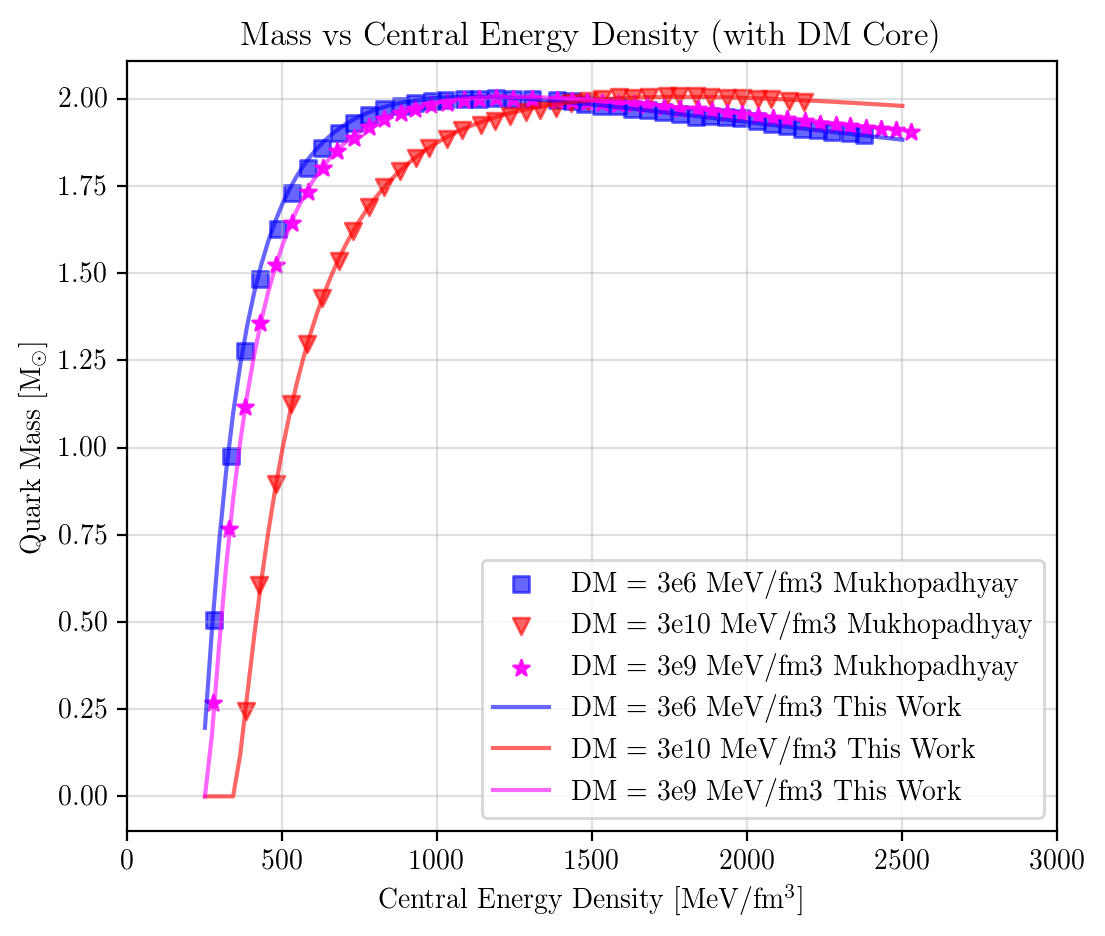

In [90]:

plt.figure(figsize=(6,5))
#plt.plot(central_energy_densities_phys, list_M, color='tab:blue', alpha=0.4)

data = pd.read_csv('../Data/two_fluids_dm3e6.csv')
plt.scatter(data['x'], data[' y'], color='blue', label='DM = 3e6 MeV/fm3 Mukhopadhyay', alpha=0.6, marker='s')

data = pd.read_csv('../Data/two_fluids_dm3e10.csv')
plt.scatter(data['x'], data[' y'], color='red', label='DM = 3e10 MeV/fm3 Mukhopadhyay', alpha=0.6, marker='v')

data = pd.read_csv('../Data/twofluids_dm3e9.csv')
plt.scatter(data['x'], data[' y'], color='fuchsia', label='DM = 3e9 MeV/fm3 Mukhopadhyay', alpha=0.9, marker='*')

plt.plot(central_energy_densities_phys, list_M_3e6, color='blue', alpha=0.6, label='DM = 3e6 MeV/fm3 This Work')
plt.plot(central_energy_densities_phys, list_M_3e10, color='red', alpha=0.6, label='DM = 3e10 MeV/fm3 This Work')
plt.plot(central_energy_densities_phys, list_M_3e9, color='fuchsia', alpha=0.6, label='DM = 3e9 MeV/fm3 This Work')

plt.xlabel("Central Energy Density [MeV/fm$^3$]")
plt.xlim(0,3000)
plt.ylabel("Quark Mass [M$_\odot$]")
plt.title("Mass vs Central Energy Density (with DM Core)")
plt.legend()
plt.grid()
plt.show()



In [105]:
q_central_energy_density = 600 * hc**3 / (4 * B) 

dm_central_energy_densities_phys = np.linspace(1e10, 4e11,50) 

central_energy_densities = dm_central_energy_densities_phys * hc**3 / (4 * B)


list_R = []
list_M = []
list_DM_mass = []

for i in range(len(central_energy_densities)):
    e_central = central_energy_densities[i]
    _ , M, R, _, Mdm= compute_two_fluid_properties(q_central_energy_density,e_central)
    list_R.append(R)
    list_M.append(M)
    list_DM_mass.append(Mdm)


   

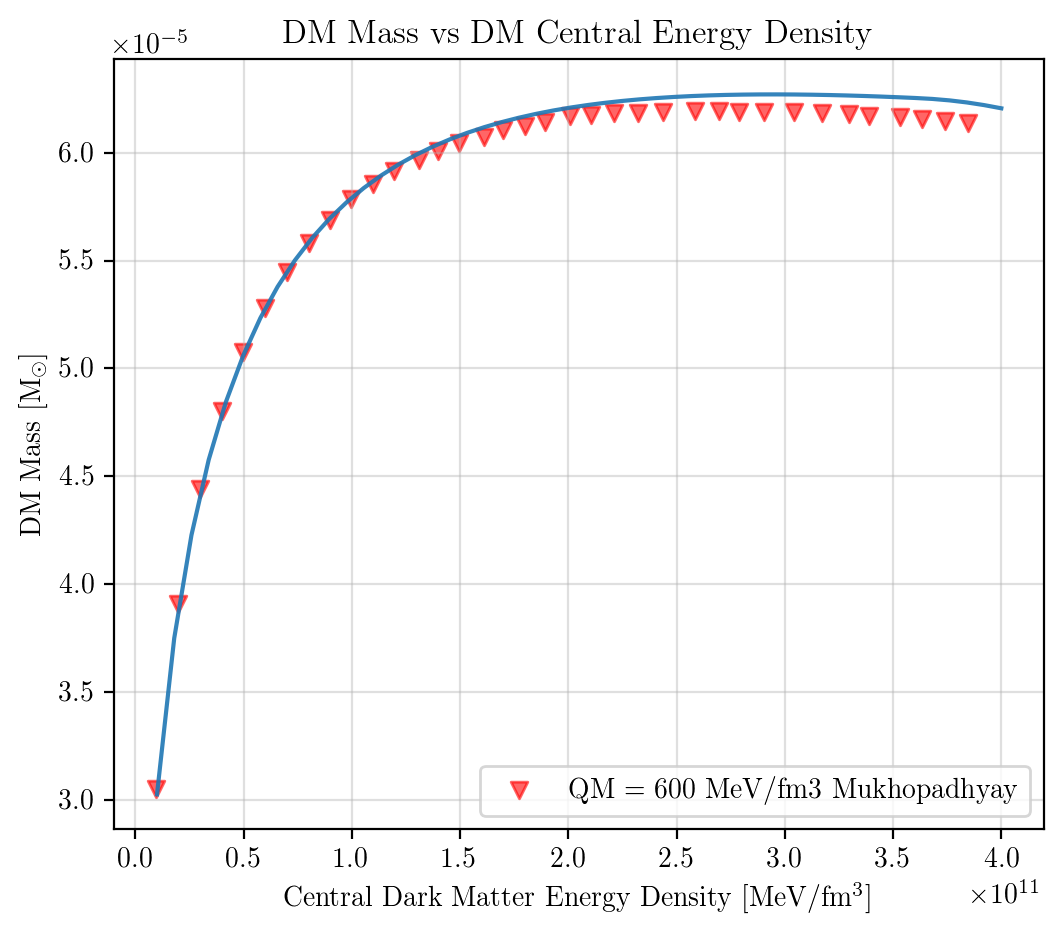

In [109]:
plt.figure(figsize=(6,5))
plt.plot(dm_central_energy_densities_phys, list_DM_mass, color='tab:blue', alpha=0.9)

data = pd.read_csv('../Data/twofluids_dm.csv')
plt.scatter(data['x'], data[' y'], color='red', label='QM = 600 MeV/fm3 Mukhopadhyay', alpha=0.6, marker='v')

plt.xlabel("Central Dark Matter Energy Density [MeV/fm$^3$]")
plt.ylabel("DM Mass [M$_\odot$]")
plt.title("DM Mass vs DM Central Energy Density")
plt.grid()
plt.legend()
plt.show()
